# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure

import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

import math as math
from mpl_toolkits.axes_grid1 import ImageGrid

## Load Image

(256, 256, 3)


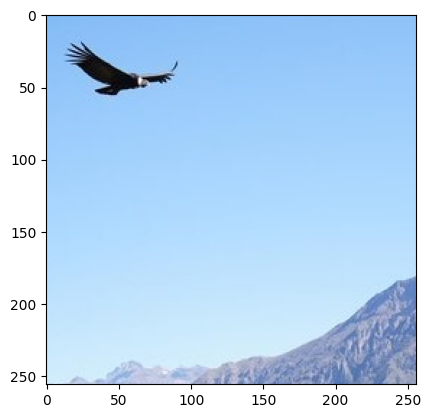

In [10]:
### START CODE HERE ###
image = cv2.imread('asset/bird.jpg')

# png to jpg
if image.shape[2] == 4: 
    image = image[:, :, :3]

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cropped_image = image[140:396, 60:316]
image = cropped_image
# image = cv2.resize(image, (530, 335))

print(image.shape)

plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

Gaussian Blur คือการใช้ Gaussian function ในการเบลอภาพ เทคนิคนี้จะใช้การคำนวณค่าเฉลี่ยน้ำหนัก (Weighted Average) ของพิกเซลในบริเวณใกล้เคียงของพิกเซลเป้าหมาย พิกเซลที่อยู่ใกล้เคียงจะมีอิทธิพลมากกว่าพิกเซลที่อยู่ไกลออกไป การกระจาย Gaussian จะมีลักษณะเป็นระฆังคว่ำ ซึ่งบ่งบอกถึงการลดอิทธิพลของพิกเซลตามระยะทาง วิธีการนี้ช่วยลด noise และรายละเอียดที่ไม่สำคัญในภาพออกไป

- (k, k): คือขนาดของ Gaussian Kernel ซึ่งต้องเป็นจำนวนคี่ เช่น (3, 3), (5, 5) เป็นต้น ขนาดที่ใหญ่ขึ้นจะทำให้ความเบลอเพิ่มขึ้น
- sigmaX: คือค่า standard deviation ในทิศทาง X หากระบุเป็น 0, OpenCV จะคำนวณค่าให้โดยอัตโนมัติ



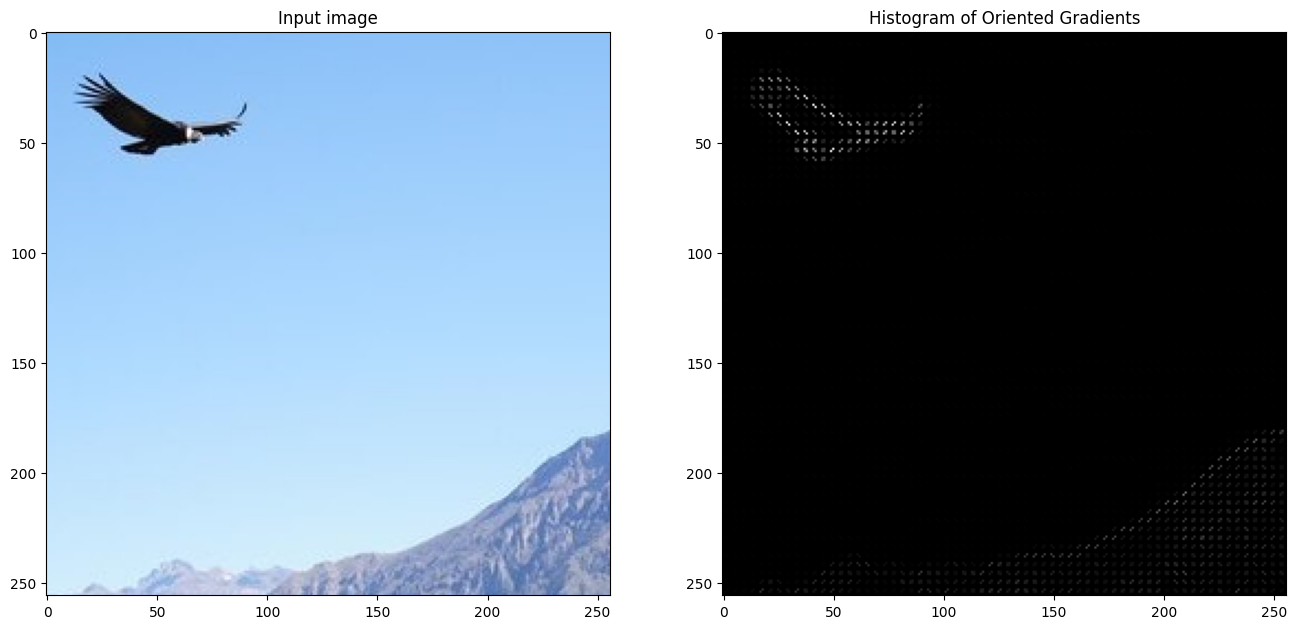

In [14]:
### START CODE HERE ###

blurry_image = cv2.GaussianBlur(image, (3, 3), 0)
# plt.imshow(blurry_image)

fd, hog_image = hog(
      blurry_image,
      # image,
      orientations=8,
      pixels_per_cell=(4, 4),
      cells_per_block=(2, 2),
      visualize=True,
      channel_axis=-1,  #ระบุว่าแชนเนลสีอยู่ที่แกนสุดท้าย เช่น (H, W, C) จะใช้ -1
  
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(image)
ax1.set_title('Input image')

ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


### END CODE HERE ###

676


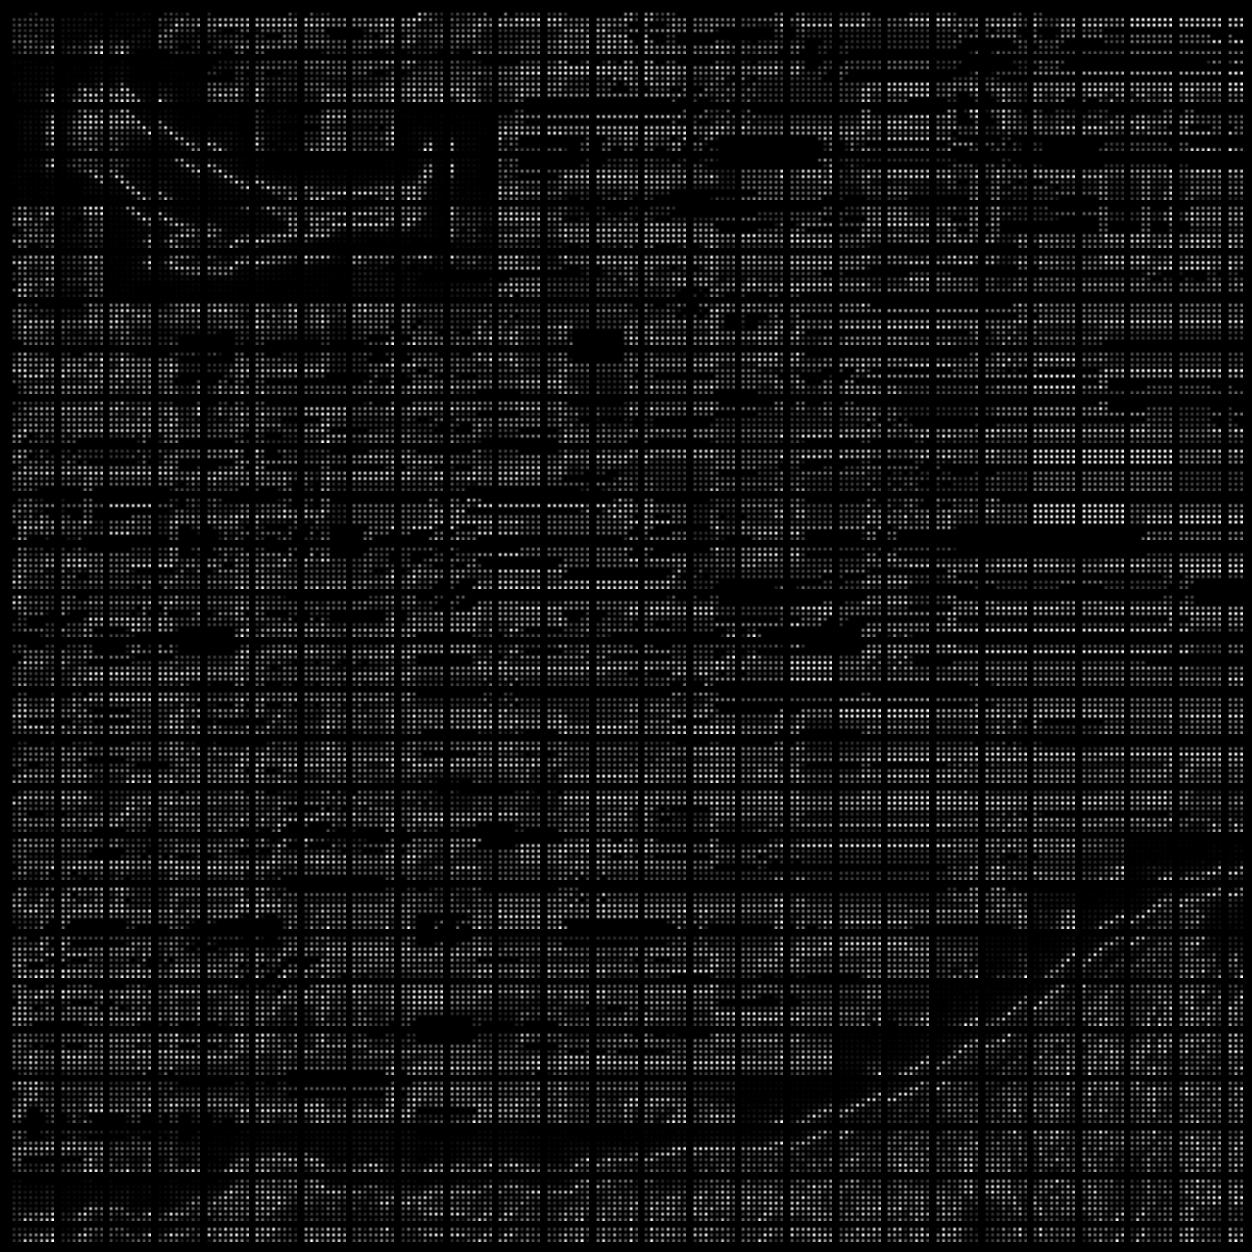

In [ ]:
"""

img_shape = image.shape
tile_size = (16, 16)
offset = (10, 10)
tiles = []


for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            cropped_img = image[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            tiles.append(cropped_img)

hog_images = []
for tile in tiles:
    fd, hog_image = hog(
        tile,
        orientations=8,
        pixels_per_cell=(2, 2),
        cells_per_block=(2, 2),
        visualize=True,
        channel_axis=-1
    )
    hog_images.append(hog_image)

fig = plt.figure(figsize=(16, 16))
plt.style.use('dark_background')

grid = ImageGrid(fig, 111,
                 nrows_ncols=(26, 26),  
                 axes_pad=0.05,  
                 )

for ax, im in zip(grid, hog_images):
    ax.axis('off')
    ax.imshow(im, cmap='gray')


print(len(tiles))

plt.show()
"""


Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [67]:
## START CODE HERE ###
class HOGSubimageExtractor:
      def __init__(self, image, tile_size, stride):
            self.image = image
            self.tile_size = tile_size
            self.stride = stride

            self.h, self.w, _ = image.shape
            self.hGrid = []
            self.wGrid = []

            self.hog_features = []
            self.hog_images = []
            self.tiles = []

            self.create_tile()
            self.extract_hog_features()

      def create_tile(self):
            for i in range(int(math.ceil(self.h/(self.stride[1] * 1.0)))):
                  for j in range(int(math.ceil(self.w/(self.stride[0] * 1.0)))):
                        cropped_img = self.image[self.stride[1]*i:min(self.stride[1]*i+self.tile_size[1], self.h), self.stride[0]*j:min(self.stride[0]*j+self.tile_size[0], self.w)]
                        
                        if cropped_img.shape[0] >= self.tile_size[0] and cropped_img.shape[1] >= self.tile_size[1]:
                              self.tiles.append(cropped_img)
            print("finish create tile")
      
      def extract_hog_features(self):
            for tile in self.tiles:
                  fd, hog_image = hog(
                        tile,
                        orientations=8,
                        pixels_per_cell=(2, 2),
                        cells_per_block=(2, 2),
                        visualize=True,
                        channel_axis=-1
                  )
                  self.hog_features.append(fd)
                  self.hog_images.append(hog_image)
            print("finish HOG")



      def plot_hog_images(self):

            grid_h, grid_w = self.calculate_grid()
            grid_image = np.zeros((grid_h, grid_w), dtype=np.uint16)

            index = 0
            for y in self.hGrid :
                  for x in self.wGrid:
                        if index >= len(self.hog_images):
                              break
                        
                        sub_img = self.hog_images[index]
                        sub_img = (sub_img - sub_img.min()) / (sub_img.max() - sub_img.min() + 1e-5)
                        sub_img = (sub_img * 255).astype(np.uint8)

                        grid_image[y:y+self.tile_size[0], x:x+self.tile_size[1]] = sub_img
                        print("index",index)
                        index += 1

            plt.figure(figsize=(16, 16)) 
            plt.imshow(grid_image, cmap='gray')
            plt.axis('off') 
            plt.show()
            

      def calculate_grid(self, padding=1):

            n_row = self.h // self.stride[0]
            n_col = self.w // self.stride[1]

            height = (n_row * (self.tile_size[0])) + padding*2
            width = (n_col * (self.tile_size[1])) + padding*2

            for r in range(n_row) :
                  self.hGrid.append(padding+ (r*self.tile_size[0]))
            for c in range(n_col) :
                  self.wGrid.append(padding+ (c*self.tile_size[1]))
            
            print("height",self.hGrid)
            print("width",self.hGrid)
            print("finish calculate grid")


            return int(height), int(width)

      def get_num_grid(self):
            return len(self.hGrid), len(self.wGrid)
## END CODE HERE ###

Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

finish create tile
finish HOG
Number of grids: (0, 0)
height [1, 17, 33, 49, 65, 81, 97, 113, 129, 145, 161, 177, 193, 209, 225, 241, 257, 273, 289, 305, 321, 337, 353, 369, 385]
width [1, 17, 33, 49, 65, 81, 97, 113, 129, 145, 161, 177, 193, 209, 225, 241, 257, 273, 289, 305, 321, 337, 353, 369, 385]
finish calculate grid
index 0
index 1
index 2
index 3
index 4
index 5
index 6
index 7
index 8
index 9
index 10
index 11
index 12
index 13
index 14
index 15
index 16
index 17
index 18
index 19
index 20
index 21
index 22
index 23
index 24
index 25
index 26
index 27
index 28
index 29
index 30
index 31
index 32
index 33
index 34
index 35
index 36
index 37
index 38
index 39
index 40
index 41
index 42
index 43
index 44
index 45
index 46
index 47
index 48
index 49
index 50
index 51
index 52
index 53
index 54
index 55
index 56
index 57
index 58
index 59
index 60
index 61
index 62
index 63
index 64
index 65
index 66
index 67
index 68
index 69
index 70
index 71
index 72
index 73
index 74
index 75
i

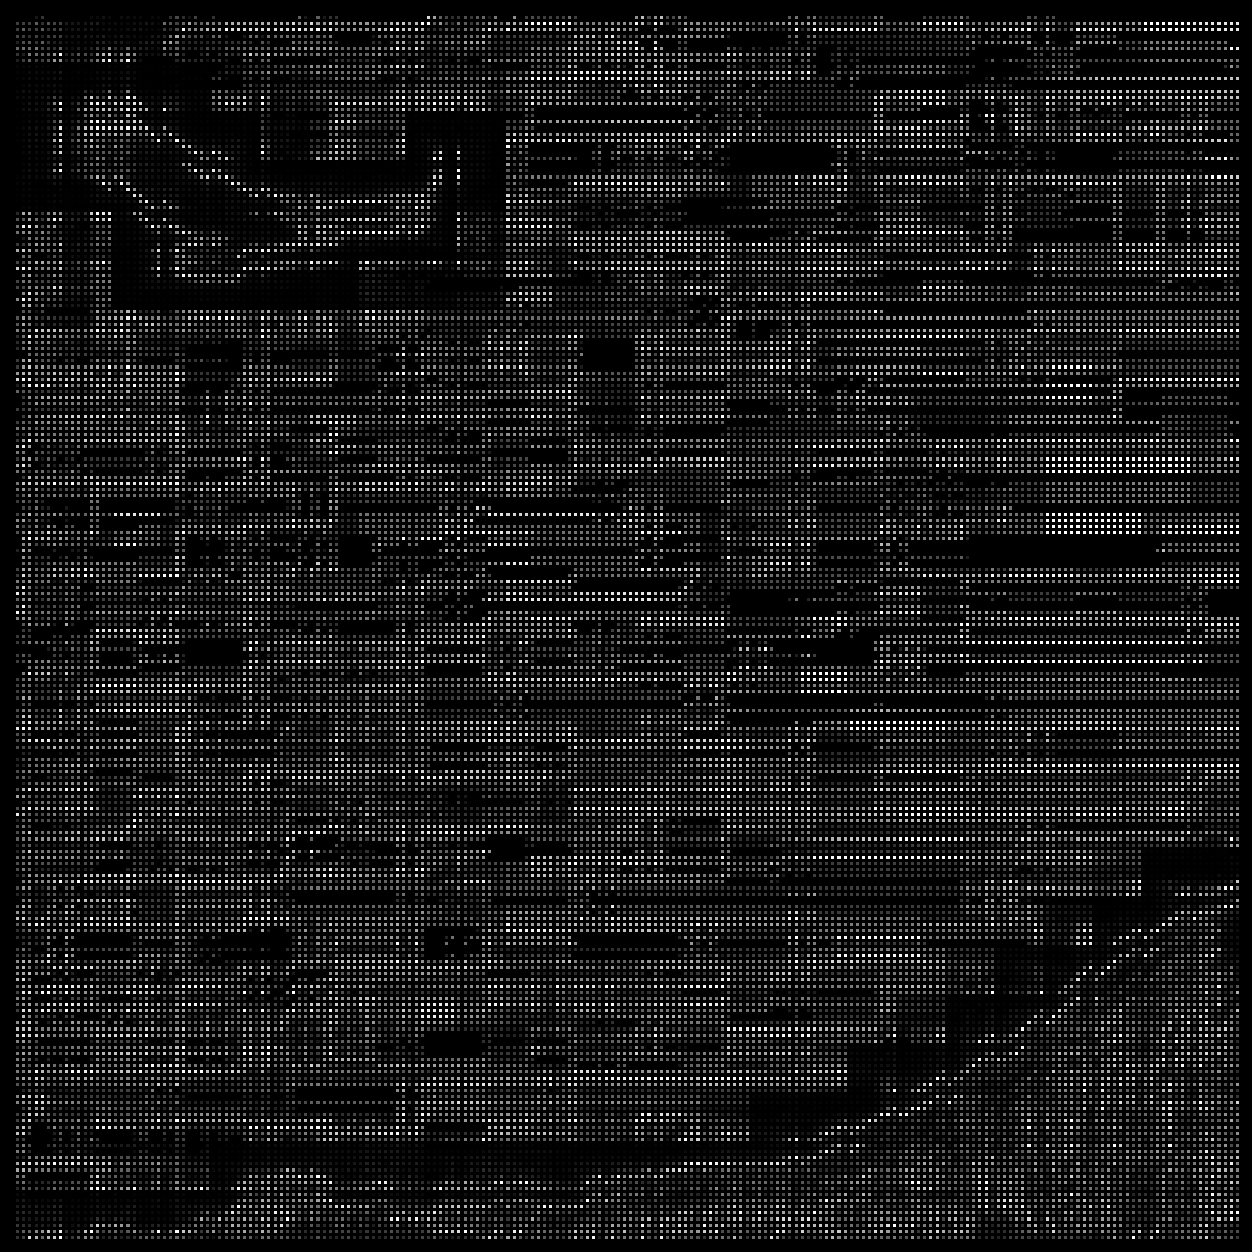

In [68]:
## START CODE HERE ###
tile_size = (16, 16)
stride = (10, 10)
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()

## END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [ ]:
### START CODE HERE ###

class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        hog_features = np.array(self.hog_extractor.hog_features)
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        kmeans.fit(hog_features)
        self.cluster_array = kmeans.labels_.reshape(self.hog_extractor.get_num_grid())
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

        print("hog_features shape:", hog_features.shape)
        print("Grid shape:", self.hog_extractor.get_num_grid())
        print("cluster_array shape:", self.cluster_array.shape)
        print("Unique cluster labels:", np.unique(self.cluster_array))
        print("Unique connected component labels:", np.unique(self.all_labels))

    def plot_cluster_and_labels(self):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        img = ax[1].imshow(self.cluster_array)
        ax[1].set_title('KMeans Cluster')
        ax[1].axis('off')
        # ax[1].imshow(self.all_labels, cmap='nipy_spectral')
        # ax[1].set_title('Connected Components')
        # ax[1].axis('off')
        plt.colorbar(img)
        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        h_num, w_num = self.hog_extractor.get_num_grid()
        tile_h, tile_w = self.hog_extractor.tile_size
        for region in measure.regionprops(self.all_labels):
            minr, minc, maxr, maxc = region.bbox
            x = minc * tile_w
            y = minr * tile_h
            w = (maxc - minc) * tile_w
            h = (maxr - minr) * tile_h
            self.bounding_boxes.append((x, y, w, h))
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [ ]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)
    
    # plt.scatter(448, 112, color='red', s=100)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

In [ ]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
boxed_image = draw_bbox(image,bboxes)

TypeError: KMeansCluster.__init__() missing 2 required positional arguments: 'n_clusters' and 'random_state'

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None



### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

In [ ]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)
